# LGBM을 활용한 베이스라인

In [81]:
import pandas as pd
import os
import random
import numpy as np

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

## 1. 데이터 로딩

In [82]:
data_dir = '/opt/ml/input/data/' # 경로는 상황에 맞춰서 수정해주세요!

# LOAD TRAINDATA
csv_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
train_data = pd.read_csv(csv_file_path)

# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_data = pd.read_csv(test_csv_file_path)
test_data['answerCode'] = test_data['answerCode'].replace(-1, np.nan)

# # LEAVE LAST INTERACTION ONLY
# train_df = test_df[test_df['userID'] == test_df['userID'].shift(-1)]
# test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# df = pd.concat([df, train_df], ignore_index=True)

## 2. Feature Engineering

In [83]:
def feature_engineering(train, test):
    ## train, test data concat
    train['train'] = 1
    test['train'] = 0
    total = pd.concat([train, test], ignore_index=True)
    
    ## 유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    total.sort_values(by=['userID','Timestamp'], inplace=True)
    total['Timestamp'] = pd.to_datetime(total['Timestamp'])
    
    ## 문제 푼 시간 재정의
    # 같은 문제 몇번째 푸는지
    total['same_item_cnt'] = total.groupby(['userID', 'assessmentItemID']).cumcount() + 1
    
    # elapsed
    # total['Timestamp'] = pd.to_datetime(total['Timestamp'])
    # # total['month'] = total['Timestamp'].dt.month
    # total['hour'] = total['Timestamp'].dt.hour
    # diff = total.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
    # diff = diff.fillna(pd.Timedelta(seconds=0))
    # diff = diff['Timestamp'].apply(lambda x: x.total_seconds())
    # total['elapsed'] = diff
    
    # 유저, test, same_item_cnt 구분했을 때 문제 푸는데 걸린 시간 > shift, fillna x
    diff_shift = total.loc[:, ['userID', 'testId', 'Timestamp', 'same_item_cnt']].groupby(['userID', 'testId', 'same_item_cnt']).diff().shift(-1)
    diff_shift = diff_shift['Timestamp'].apply(lambda x: x.total_seconds())
    total['solved_time_shift'] = diff_shift
    # total['solved_time_shift'] = total.groupby(['userID', 'testId', 'same_item_cnt'])['solved_time_shift'].apply(lambda x:x.fillna(x.mean()))
    
    # 1. agg 값 구하기
    ## 1-1. 유저/문제/시험지/태그별 평균 정답률
    total['user_avg'] = total.groupby('userID')['answerCode'].transform('mean')
    total['item_avg'] = total.groupby('assessmentItemID')['answerCode'].transform('mean')
    total['test_avg'] = total.groupby('testId')['answerCode'].transform('mean')
    total['tag_avg'] = total.groupby('KnowledgeTag')['answerCode'].transform('mean')

    ## 1-2. 유저/문제/시험지별 평균 풀이시간
    total['user_time_avg'] = total.groupby('userID')['solved_time_shift'].transform('mean')
    total['item_time_avg'] = total.groupby('assessmentItemID')['solved_time_shift'].transform('mean')
    total['test_time_avg'] = total.groupby('testId')['solved_time_shift'].transform('mean')
    total['tag_time_avg'] = total.groupby('KnowledgeTag')['solved_time_shift'].transform('mean')
    
    # 맞은 사람의 문제별 평균 풀이시간
    total = total.set_index('assessmentItemID')
    total['Item_mean_solved_time'] = total[total['answerCode'] == 1].groupby('assessmentItemID')['solved_time_shift'].mean()
    total = total.reset_index(drop = False)
     
    # 유저/문제/시험지/태그별 표준편차
    total['user_std'] = total.groupby('userID')['answerCode'].transform('std')
    total['item_std'] = total.groupby('assessmentItemID')['answerCode'].transform('std')
    total['test_std'] = total.groupby('testId')['answerCode'].transform('std')
    total['tag_std'] = total.groupby('KnowledgeTag')['answerCode'].transform('std')
    
    ## 1-3. 현재 유저의 해당 문제지 평균 정답률/풀이시간
    total['user_current_avg'] = total.groupby(['userID', 'testId', 'same_item_cnt'])['answerCode'].transform('mean')
    total['user_current_time_avg'] = total.groupby(['userID', 'testId', 'same_item_cnt'])['solved_time_shift'].transform('mean')
    
    # 2. 컬럼 추가
    total['hour'] = total['Timestamp'].dt.hour
    total['hour'] = total['hour'].astype('category')
    
    total['month'] = total['Timestamp'].dt.month
    total['month'] = total['month'].astype('category')
    
    ## 문제 번호 추가
    total['item_num'] = total['assessmentItemID'].str[7:]
    total['item_num'] = total['item_num'].astype('category')
    # in2idx = {v:k for k,v in enumerate(df['item_num'].unique())}
    # df['item_num'] = df['item_num'].map(in2idx)
    
    ## 문제 푼 순서 추가 > 상대적 순서?
    total['item_seq'] = total.groupby(['userID', 'testId', 'same_item_cnt']).cumcount() +1
    total['item_seq'] = total['item_seq'].astype('category')
    # df['item_seq'] = df['item_seq'] - df['item_num'].astype(int)
    # df['item_num'] = df['item_num'].astype('category')
    # is2idx = {v:k for k,v in enumerate(df['item_seq'].unique())}
    # df['item_seq'] = df['item_seq'].map(is2idx)
    
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    # df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    # df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    # df['user_acc'] = df['user_correct_answer']/df['user_total_answer']
    
    # diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
    # diff = diff.fillna(pd.Timedelta(seconds=0))
    # diff = diff['Timestamp'].apply(lambda x: x.total_seconds())
    # df['elapsed'] = diff
    
    total['Bigcat'] = total['testId'].str[2]
    total['Bigcat'] = total['Bigcat'].astype('category')
    
    total['smallcat'] = total['testId'].str[7:10]
    total['smallcat'] = total['smallcat'].astype('category')
#     sc2idx = {v:k for k,v in enumerate(df['smallcat'].unique())}
#     df['smallcat'] = df['smallcat'].map(sc2idx)

#     # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
#     # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
#     correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
#     correct_t.columns = ["test_mean", 'test_sum']
#     correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
#     correct_k.columns = ["tag_mean", 'tag_sum']

#     df = pd.merge(df, correct_t, on=['testId'], how="left")
#     df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")

    ## train, test 나누어서 return
    train_df = total[total['train']==1]
    test_df = total[total['train']==0]
    test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]
    
    
    return train_df, test_df

In [84]:
df, submission = feature_engineering(train_data, test_data)
display(df)
display(submission)

,assessmentItemID,userID,testId,answerCode,Timestamp,KnowledgeTag,train,same_item_cnt,solved_time_shift,user_avg,...,test_std,tag_std,user_current_avg,user_current_time_avg,hour,month,item_num,item_seq,Bigcat,smallcat
0,A060001001,0,A060000001,1.0,2020-03-24 00:17:11,7224,1,1,3.0,0.630872,...,0.212422,0.202239,1.0,7.200000,0,3,001,1,6,001
1,A060001002,0,A060000001,1.0,2020-03-24 00:17:14,7225,1,1,8.0,0.630872,...,0.212422,0.275818,1.0,7.200000,0,3,002,2,6,001
2,A060001003,0,A060000001,1.0,2020-03-24 00:17:22,7225,1,1,7.0,0.630872,...,0.212422,0.275818,1.0,7.200000,0,3,003,3,6,001
3,A060001004,0,A060000001,1.0,2020-03-24 00:17:29,7225,1,1,7.0,0.630872,...,0.212422,0.275818,1.0,7.200000,0,3,004,4,6,001
4,A060001005,0,A060000001,1.0,2020-03-24 00:17:36,7225,1,1,11.0,0.630872,...,0.212422,0.275818,1.0,7.200000,0,3,005,5,6,001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,A030071005,7441,A030000071,0.0,2020-06-05 06:50:21,438,1,1,NaN,0.555556,...,0.471797,0.460506,0.2,55.000000,6,6,005,5,3,071
2526696,A040165001,7441,A040000165,1.0,2020-08-21 01:06:39,8836,1,1,11.0,0.555556,...,0.475931,0.458311,1.0,43.333333,1,8,001,1,4,165
2526697,A040165002,7441,A040000165,1.0,2020-08-21 01:06:50,8836,1,1,46.0,0.555556,...,0.475931,0.458311,1.0,43.333333,1,8,002,2,4,165
2526698,A040165003,7441,A040000165,1.0,2020-08-21 01:07:36,8836,1,1,73.0,0.555556,...,0.475931,0.458311,1.0,43.333333,1,8,003,3,4,165


,assessmentItemID,userID,testId,answerCode,Timestamp,KnowledgeTag,train,same_item_cnt,solved_time_shift,user_avg,...,test_std,tag_std,user_current_avg,user_current_time_avg,hour,month,item_num,item_seq,Bigcat,smallcat
2989,A050133008,3,A050000133,NaN,2020-10-26 13:13:57,5289,0,1,NaN,0.692754,...,0.475380,0.496517,0.857143,45.142857,13,10,008,8,5,133
3660,A070146008,4,A070000146,NaN,2020-12-27 02:47:54,9080,0,1,NaN,0.694030,...,0.476573,0.497938,0.857143,24.571429,2,12,008,8,7,146
10860,A070111008,13,A070000111,NaN,2020-12-27 04:35:09,9660,0,1,NaN,0.695289,...,0.498249,0.500051,0.428571,14.857143,4,12,008,8,7,111
15278,A090064006,17,A090000064,NaN,2020-10-30 05:48:37,2611,0,1,NaN,0.818904,...,0.497463,0.493738,1.000000,76.000000,5,10,006,6,9,064
23531,A060135007,26,A060000135,NaN,2020-10-23 11:44:18,1422,0,1,NaN,0.759067,...,0.480030,0.487891,0.666667,45.833333,11,10,007,7,6,135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525938,A040122005,7395,A040000122,NaN,2020-09-08 02:05:20,10615,0,1,NaN,0.304348,...,0.406591,0.457593,0.250000,3.000000,2,9,005,5,4,122
2526081,A030111005,7404,A030000111,NaN,2020-10-13 09:49:18,7636,0,1,NaN,0.500000,...,0.339423,0.380394,0.500000,54.750000,9,10,005,5,3,111
2526282,A050193004,7416,A050000193,NaN,2020-10-04 02:44:41,10402,0,1,NaN,0.500000,...,0.433519,0.381202,0.666667,15.666667,2,10,004,4,5,193
2526297,A050193004,7417,A050000193,NaN,2020-09-06 13:09:15,10402,0,1,NaN,0.142857,...,0.433519,0.381202,0.666667,21.000000,13,9,004,4,5,193


In [85]:
df.columns

Index(['assessmentItemID', 'userID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'train', 'same_item_cnt', 'solved_time_shift',
       'user_avg', 'item_avg', 'test_avg', 'tag_avg', 'user_time_avg',
       'item_time_avg', 'test_time_avg', 'tag_time_avg',
       'Item_mean_solved_time', 'user_std', 'item_std', 'test_std', 'tag_std',
       'user_current_avg', 'user_current_time_avg', 'hour', 'month',
       'item_num', 'item_seq', 'Bigcat', 'smallcat'],
      dtype='object')

## 3. Train/Test 데이터 셋 분리

In [86]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [87]:
# 유저별 분리
train, test = custom_train_test_split(df)
print(train.columns)

Index(['assessmentItemID', 'userID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'train', 'same_item_cnt', 'solved_time_shift',
       'user_avg', 'item_avg', 'test_avg', 'tag_avg', 'user_time_avg',
       'item_time_avg', 'test_time_avg', 'tag_time_avg',
       'Item_mean_solved_time', 'user_std', 'item_std', 'test_std', 'tag_std',
       'user_current_avg', 'user_current_time_avg', 'hour', 'month',
       'item_num', 'item_seq', 'Bigcat', 'smallcat'],
      dtype='object')


In [97]:
# 사용할 Feature 설정
# FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
#          'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum', 'elapsed','Bigcat','smallcat']
# FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
#          'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum', 'elapsed', 'Bigcat', 'smallcat', 'item_num', 'item_seq', 'solved_time_shift']
FEATS = ['KnowledgeTag', 'same_item_cnt', 'user_avg', 'item_avg', 'test_avg', 'tag_avg', 'user_time_avg', 'item_time_avg',
       'test_time_avg', 'tag_time_avg', 'user_current_avg', 'user_current_time_avg', 'hour', 'item_num', 'Bigcat','smallcat']

In [98]:
# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

KeyError: 'answerCode'

In [99]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증

In [100]:
model = lgb.train(
    {'learning_rate': 0.001, 
      'objective': 'binary', 
      'metric': 'binary_logloss',
      'sub_feature': 0.5, 
      'num_leaves': 10, 
      'min_data': 50, 
      'max_depth': 10}, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=2000,
    early_stopping_rounds=100
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1039565, number of negative: 546592
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2856
[LightGBM] [Info] Number of data points in the train set: 1586157, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655399 -> initscore=0.642855
[LightGBM] [Info] Start training from score 0.642855
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's binary_logloss: 0.615277	valid_1's binary_logloss: 0.718854
[200]	training's binary_logloss: 0.586807	valid_1's binary_logloss: 0.685401
[300]	training's binary_logloss: 0.565293	valid_1's binary_logloss: 0.660143
[400]	training's binary_logloss: 0.545766	valid_1's binary_logloss: 0.637309
[500]	training's binary_logloss: 0.527307	valid_1's binary_logloss: 0.615613
[600]	training's binary_logloss: 0.511408	valid_1's binary_logloss: 0.596992
[700]	training's binary_logloss: 0.497927	valid_1's binary_logloss: 0.581289
[800]	training's binary_logloss: 0.484506	valid_1's binary_logloss: 0.565685
[900]	training's binary_logloss: 0.472242	valid_1's binary_logloss: 0.551543
[1000]	training's binary_logloss: 0.463271	valid_1's binary_logloss: 0.541003
[1100]	training's binary_logloss: 0.454452	valid_1's binary_logloss: 0.530689
[1200]	training's binary_logloss: 0.445384	valid_1's binary_logloss: 0.519982
[1300]	training's binary_logloss: 0.437125	valid_1's binary_logloss: 0.51

## 5. Inference

In [101]:
# # LOAD TESTDATA
# test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
# test_df = pd.read_csv(test_csv_file_path)

# # FEATURE ENGINEERING
# test_df = feature_engineering(test_df)

# # LEAVE LAST INTERACTION ONLY
# test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# submission = submission[FEATS]
submission.head(10)


# # DROP ANSWERCODE
# test_df = test_df.drop(['answerCode'], axis=1)

,assessmentItemID,userID,testId,answerCode,Timestamp,KnowledgeTag,train,same_item_cnt,solved_time_shift,user_avg,...,test_std,tag_std,user_current_avg,user_current_time_avg,hour,month,item_num,item_seq,Bigcat,smallcat
2989,A050133008,3,A050000133,NaN,2020-10-26 13:13:57,5289,0,1,NaN,0.692754,...,0.475380,0.496517,0.857143,45.142857,13,10,008,8,5,133
3660,A070146008,4,A070000146,NaN,2020-12-27 02:47:54,9080,0,1,NaN,0.694030,...,0.476573,0.497938,0.857143,24.571429,2,12,008,8,7,146
10860,A070111008,13,A070000111,NaN,2020-12-27 04:35:09,9660,0,1,NaN,0.695289,...,0.498249,0.500051,0.428571,14.857143,4,12,008,8,7,111
15278,A090064006,17,A090000064,NaN,2020-10-30 05:48:37,2611,0,1,NaN,0.818904,...,0.497463,0.493738,1.000000,76.000000,5,10,006,6,9,064
23531,A060135007,26,A060000135,NaN,2020-10-23 11:44:18,1422,0,1,NaN,0.759067,...,0.480030,0.487891,0.666667,45.833333,11,10,007,7,6,135
26895,A020190005,29,A020000190,NaN,2020-10-22 04:38:45,8097,0,1,NaN,0.847597,...,0.438876,0.453456,1.000000,26.000000,4,10,005,5,2,190
39887,A040136005,45,A040000136,NaN,2020-10-23 08:24:19,2107,0,1,NaN,0.688827,...,0.448255,0.457104,0.250000,25.000000,8,10,005,5,4,136
47628,A040140005,53,A040000140,NaN,2020-10-26 09:13:20,2110,0,1,NaN,0.523121,...,0.452402,0.452832,0.500000,10.250000,9,10,005,5,4,140
51927,A070159007,58,A070000159,NaN,2020-12-24 21:09:29,9122,0,1,NaN,0.364198,...,0.499640,0.482075,0.142857,1.857143,21,12,007,8,7,159
57352,A070146008,64,A070000146,NaN,2020-12-29 04:30:22,9080,0,1,NaN,0.833727,...,0.476573,0.497938,1.000000,1.714286,4,12,008,8,7,146


In [102]:
# MAKE PREDICTION
total_preds = model.predict(submission[FEATS])
total_preds[:10]

array([0.72653343, 0.75200718, 0.3400385 , 0.80987768, 0.44989513,
       0.8902278 , 0.37933238, 0.31673849, 0.22357008, 0.85903193])

In [103]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "lgbm_cet_submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/lgbm_cet_submission.csv


###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.



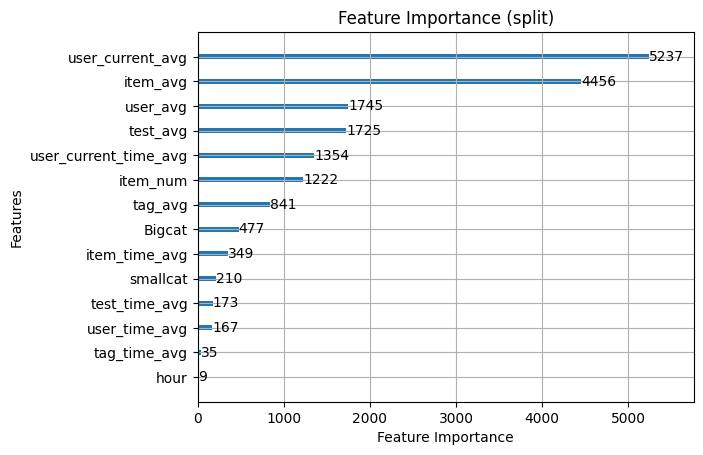

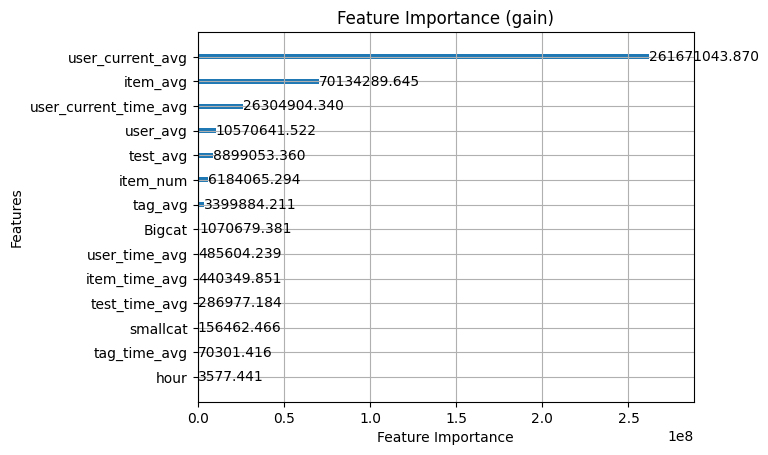

In [104]:
# model: 이미 학습이 완료된 LGBMModel, or Booster
# FEATURES: model 학습에 사용된 모든 features
# PATH: 그림을 저장할 경로

# SPLIT
ax = lgb.plot_importance(model, max_num_features=len(FEATS), importance_type='split')
ax.set(title=f'Feature Importance (split)',
	xlabel='Feature Importance',
	ylabel='Features')
ax.figure.savefig(f'./output/fi_split.png', dpi=300)


# GAIN
ax = lgb.plot_importance(model, max_num_features=len(FEATS), importance_type='gain')
ax.set(title=f'Feature Importance (gain)',
	xlabel='Feature Importance',
	ylabel='Features')
ax.figure.savefig(f'./output/fi_gain.png', dpi=300)